# 카메라 스티커앱 만들기 첫걸음 퀘스트


In [1]:
# 필요한 패키지 import 하기
import os # 환경 변수나 디렉터리, 파일 등의 OS 자원을 제어할 수 있게 해주는 모듈
import cv2 # OpenCV라이브러리 → 컴퓨터 비전 관련 프로그래밍을 쉽게 할 수 있도록 도와주는 라이브러리
import matplotlib.pyplot as plt # 다양한 데이터를 많은 방법으로 도식화 할 수 있도록 하는 라이브러리
import numpy as np # 다차원 배열을 쉽게 처리하고 효율적으로 사용할 수 있도록 하는 라이브러리
import dlib # 이미지 처리 및 기계 학습, 얼굴인식 등을 할 수 있는 c++ 로 개발된 고성능의 라이브러리 


shape_predictor_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.png'
my_image_path2 = os.getenv('HOME')+'/aiffel/camera_sticker/images/image2.jpg' 
my_image_path3 = os.getenv('HOME')+'/aiffel/camera_sticker/images/image3.jpg'
my_image_path4 = os.getenv('HOME')+'/aiffel/camera_sticker/images/image4.jpg' 
my_sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'


my_debug = False

## 클래스

In [2]:
# 스티커 앱 클래스 작성

class FaceStickerApp:
    def __init__(self,sticker_path):
        # 얼굴 탐지기(HOG 기반)
        self.face_detector = dlib.get_frontal_face_detector()
        # 얼굴 랜드마크 예측기
        self.landmark_predictor = dlib.shape_predictor(shape_predictor_path)
        # 스티커 이미지 불러오기
        self.sticker = cv2.imread(sticker_path)

    def process_image(self, image_path):
        image = cv2.imread(image_path)
        
        img_rgb =  cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # 얼굴 탐지
        faces = self.face_detector(img_rgb,1)

        # 각 얼굴에 스티커 적용
        for face in faces:
            image = self.apply_sticker(image, face)
            
            if (my_debug): # Debug용 코드
                l = face.left() # 왼쪽
                t = face.top() # 위쪽
                r = face.right() # 오른쪽
                b = face.bottom() # 아래쪽
                cv2.rectangle(image, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림
        return image
    
    
    def apply_sticker(self, image, face):
        x = face.left()
        y = face.top()
        w = face.width()
        h = face.height()

        # landmark_predictor 는 rgb 를 사용하므로 변경
        img_rgb =  cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        landmarks = self.landmark_predictor(img_rgb, face)
        
        # 스티커 부착 기준점
        base_point = landmarks.part(33)
        base_point.x = (landmarks.part(33).x +landmarks.part(51).x) //2
        base_point.y = (landmarks.part(33).y +landmarks.part(51).y) //2
        
        # 스티커 사이즈 얼굴 크기에 맞게 조정
        sticker_resized = cv2.resize(self.sticker, (w,h))
        img_sticker = sticker_resized
        
        # 스티커 위치 계산
        refined_x = base_point.x - w // 2
        refined_y = base_point.y -  h//2
        
        # 위치 0 이하 -> 0
        if refined_x < 0: 
            img_sticker = sticker_resized[:, -refined_x:]
            refined_x = 0
        if refined_y < 0:
            img_sticker = sticker_resized[-refined_y:, :]
            refined_y = 0
            
        # 이미지 영역을 넘는 부분 자르기
        img_h, img_w = image.shape[:2]
        st_h, st_w = img_sticker.shape[:2]
        
        if refined_x + st_w > img_w:
            img_sticker = img_sticker[:, :img_w - refined_x]
        if refined_y + st_h > img_h:
            img_sticker = img_sticker[:img_h - refined_y, :]
        
        st_h, st_w = img_sticker.shape[:2]
        
        sticker_area = image[refined_y:refined_y+st_h, refined_x:refined_x+st_w]

        # 투명도 적용
        image[refined_y:refined_y+st_h, refined_x:refined_x+st_w] = \
            cv2.addWeighted( sticker_area, 0.5,
                            np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8),1-0.5 ,0)
        return image    
    


## 정면 바른 각도 확인

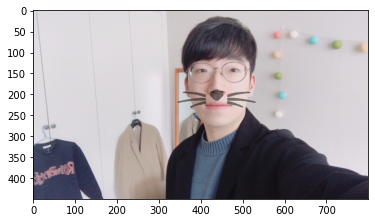

In [3]:

app = FaceStickerApp(my_sticker_path)
img_show = app.process_image(my_image_path)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## 옆모습 확인

90도가까이까지는 인식이 되는데 그 이상이 되면 인식이 되지 않는듯합니다.

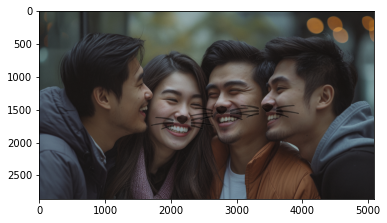

In [5]:
app2 = FaceStickerApp(my_sticker_path)
img_show2 = app2.process_image(my_image_path2)
plt.imshow(cv2.cvtColor(img_show2, cv2.COLOR_BGR2RGB))
plt.show()

## 다양한 각도 확인

각도에 따라 인식이 되는 부분과 아닌 부분으 확인했습니다. 
정방향의 약간의 각도 변화까지는 인식을 했지만 각도가 임계치 이상이 되면 검출이 안됩니다.

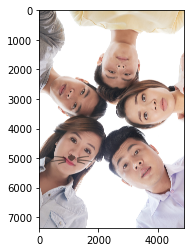

In [7]:
app3 = FaceStickerApp(my_sticker_path)
img_show3 = app3.process_image(my_image_path3)
plt.imshow(cv2.cvtColor(img_show3, cv2.COLOR_BGR2RGB))
plt.show()

## 먼 곳과 어두운 부분 확인

어두운 부분과 멀어서 얼굴이 작은 부분이 인식이 잘안되는 것을 볼 수 있습니다.

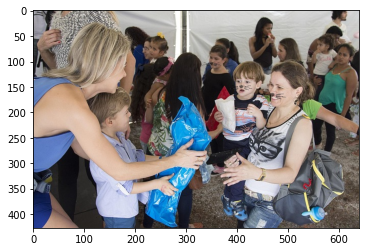

In [9]:
app4 = FaceStickerApp(my_sticker_path)
img_show4 = app4.process_image(my_image_path4)
plt.imshow(cv2.cvtColor(img_show4, cv2.COLOR_BGR2RGB))
plt.show()

# 회고
 앱을 만드는 퀘스트라 재사용성을 위해 클래스를 사용했습니다. 기능별로 나열된 예제 코드들을 하나의 클래스로 정리하다보니 내용에 대해 이해가 더 되었던것 같습니다. 처음 설계시에 클래스를 몇개를 더 생각했으나 모델이나 디텍터등을 기존 클래스를 사용해서 불필요한 클래스들이 많아져 좀 더 단순하게 생각해야겠다라는 생각을 했습니다. 다양한 사진을 통해 문제점을 파악하였으나 능력과 시간 부족으로 해결한 부분은 없습니다. 속도의 문제도 실제 사용하기에는 너무 느리다고 생각했습니다. 어느정도 배울 수 있었지만 아쉬움이 많이 남는 퀘스트였습니다.